# Basic Monthly Current Population Survey (CPS) Data Analysis, Changes in Income and Employment Based on Race
- Ursaminor Jupyter Notebook
- 20 November 2020
- By Barnett Yang

## Table of Contents

## Goals
- Analyze raw CPS data and partition data according to race.
- Track changes in income and employment based on race across the COVID-19 Pandemic (time period of interest is January to September, 2020).
- Form conclusions regarding the impacts of the economic fallout resultant from the COVID-19 pandemic on academic performance based on race.

## Miscellaneous Notes and Libraries
- CPS datasets can be found on this website under the CSV tab: https://data.nber.org/data/cps-basic2/.
- The data dictionary for the relevant datasets can be found here: https://www2.census.gov/programs-surveys/cps/datasets/2020/basic/2020_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt.
- This might be good reading: https://www.brookings.edu/wp-content/uploads/2020/06/Han-et-al-conference-draft.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7, 8.27)})

## Indicators and Relevant Variables

### Demographic Variables
- ptdtrace: Race
    - For simplicity, and to be consistent with the analysis done for the Household Pulse Survey and High School Longitudinal Study, we will not consider those of mixed races and will only do so if time permits.
    - 01: White only.
    - 02: Black only.
    - 03: American Indian, Alaskan Native only.
    - 04: Asian only.
    - 05: Hawaiian/Pacific Islander only.
- pehspnon: Hispanic or non-Hispanic
    - For simplicity, and to be consistent with the analysis done for the Household Pulse Survey and High School Longitudinal Study, we will not consider those of mixed races and will only do so if time permits.
    - 1: Hispanic.
    - 2: Non-Hispanic.

### Income and Employment Variables
- hefaminc: Family Income, in dollars (Combined income of all family members during the last 12 months. Includes money from jobs, net income from business, farm or rent, pensions, dividents, interest, Social Security payments and any other money income received by family members who are 15 years of age or older)
    - 1: less than 5000
    - 2: 5000 to 7499
    - 3: 7500 to 9999
    - 4: 10000 to 12499
    - 5: 12500 to 14999
    - 6: 15000 to 19999
    - 7: 20000 to 24999
    - 8: 25000 to 29999
    - 9: 30000 to 34999
    - 10: 35000 to 39999
    - 11: 40000 to 49999
    - 12: 50000 to 59999
    - 13: 60000 to 74999
    - 14: 75000 to 99999
    - 15: 100000 to 149999
    - 16: 150000 or more
- pemlr: Month Labor Force Recode
    - 1: Employed - at work
    - 2: Employed - absent
    - 3: Unemployed - on layoff
    - 4: Unemployed - looking
    - 5: Not in labor force - retired
    - 6: Not in labor force - disabled
    - 7: Not in labor force - other
- puwk: Last week, did you do any work for (either) pay (or profit)?
    - 1: Yes
    - 2: No
    - 3: Retired
    - 4: Disabled
    - 5: Unable to work
    - Do not consider negative values, since those likely indicate non-respondants
- puabsot: Last week, did you have a job either full or part-time?
    - 1: Yes
    - 2: No
    - 3: Retired
    - 4: Disabled
    - 5: Unable to work
    - Do not consider negative values, since those likely indicate non-respondants
    - May not be a good indicator. ~90% of values are negative (non-respondant or N/A)
- pulay: Last week, were you on layoff from a job?
    - 1: Yes
    - 2: No
    - 3: Retired
    - 4: Disabled
    - 5: Unable to work
    - Do not consider negative values, since those likely indicate non-respondants
    - May not be a good indicator. ~90% of values are negative (non-respondant or N/A)
- Can consider other factors later if time permits.

## Upload Data and Constants

In [30]:
# Demographic variables
dem_vars = ['ptdtrace', 'pehspnon']
# Income and Employment variables
eco_vars = ['hefaminc', 'pemlr', 'puwk', 'puabsot', 'pulay']

all_vars = dem_vars + eco_vars

# Data
jan = pd.read_csv('../data/Current_Population_Survey/cpsb202001.csv', usecols=all_vars)
feb = pd.read_csv('../data/Current_Population_Survey/cpsb202002.csv', usecols=all_vars)
mar = pd.read_csv('../data/Current_Population_Survey/cpsb202003.csv', usecols=all_vars)
apr = pd.read_csv('../data/Current_Population_Survey/cpsb202004.csv', usecols=all_vars)
may = pd.read_csv('../data/Current_Population_Survey/cpsb202005.csv', usecols=all_vars)
jun = pd.read_csv('../data/Current_Population_Survey/cpsb202006.csv', usecols=all_vars)
jul = pd.read_csv('../data/Current_Population_Survey/cpsb202007.csv', usecols=all_vars)
aug = pd.read_csv('../data/Current_Population_Survey/cpsb202008.csv', usecols=all_vars)
sep = pd.read_csv('../data/Current_Population_Survey/cpsb202009.csv', usecols=all_vars)

# Data consolidated into a list
months = [jan, feb, mar, apr, may, jun, jul, aug, sep]

### Functions

In [31]:
# Creates a dataframe for a specific race with only income data
def analyze_income_race(race_num):
    race_months = [i[i['ptdtrace'] == race_num] for i in months]
    race_income = pd.DataFrame()
    
    for i in range(len(race_months)):
        month_income = race_months[i]['hefaminc'].value_counts().to_frame()
        num_drop = len([i for i in month_income.index if i < 0])
        month_income = month_income.sort_index().iloc[num_drop:]
        month_income['PERCENT'] = month_income['hefaminc'] / month_income['hefaminc'].sum() * 100
    
        race_income['MONTH ' + str(i + 1) + ' INCOME'] = month_income['hefaminc']
        race_income['MONTH ' + str(i + 1) + ' PERCENT'] = month_income['PERCENT']
    
    for i in range(1, 17):
        race_income = race_income.rename(index={i: 'INCOME BRACKET ' + str(i)})
    
    return race_income

# Creates a dataframe for a specific race with only employment data
def analyze_emp_race(race_num):
    if race_num == "hispanic":
        race_months = [i[i['pehspnon'] == 1] for i in months]
    else:
        race_months = [i[i['ptdtrace'] == race_num] for i in months]
    
    race_emp = pd.DataFrame()
    
    for i in range(len(race_months)):
        month_emp = race_months[i]['pemlr'].value_counts().to_frame()
        num_drop = len([i for i in month_emp.index if i < 0])
        month_emp = month_emp.sort_index().iloc[num_drop:]
        month_emp['PERCENT'] = month_emp['pemlr'] / month_emp['pemlr'].sum() * 100
    
        race_emp['MONTH ' + str(i + 1) + ' EMPLOYMENT'] = month_emp['pemlr']
        race_emp['MONTH ' + str(i + 1) + ' PERCENT'] = month_emp['PERCENT']
    
    for i in range(1, 17):
        race_emp = race_emp.rename(index={i: 'EMPLOYMENT BRACKET ' + str(i)})
    
    return race_emp

## Changes in Family Income Based on Race

### Overall: All Races

In [4]:
all_income = pd.DataFrame()

for i in range(len(months)):
    month_income = months[i]['hefaminc'].value_counts().to_frame()
    num_drop = len([i for i in month_income.index if i < 0])
    month_income = month_income.sort_index().iloc[num_drop:]
    month_income['PERCENT'] = month_income['hefaminc'] / month_income['hefaminc'].sum() * 100
    all_income['MONTH ' + str(i + 1) + ' INCOME'] = month_income['hefaminc']
    all_income['MONTH ' + str(i + 1) + ' PERCENT'] = month_income['PERCENT']
for i in range(1, 17):
    all_income = all_income.rename(index={i: 'INCOME BRACKET ' + str(i)})
    
all_income

,MONTH 1 INCOME,MONTH 1 PERCENT,MONTH 2 INCOME,MONTH 2 PERCENT,MONTH 3 INCOME,MONTH 3 PERCENT,MONTH 4 INCOME,MONTH 4 PERCENT,MONTH 5 INCOME,MONTH 5 PERCENT,MONTH 6 INCOME,MONTH 6 PERCENT,MONTH 7 INCOME,MONTH 7 PERCENT,MONTH 8 INCOME,MONTH 8 PERCENT,MONTH 9 INCOME,MONTH 9 PERCENT
INCOME BRACKET 1,2270,1.936216,2223,1.885976,1820,1.735350,1498,1.474337,1266,1.295035,1148,1.227243,1186,1.240534,1384,1.388137,1868,1.680884
INCOME BRACKET 2,1082,0.922901,1076,0.912870,859,0.819047,748,0.736184,661,0.676159,578,0.617898,620,0.648508,630,0.631883,927,0.834143
INCOME BRACKET 3,1665,1.420176,1687,1.431238,1347,1.284349,1232,1.212539,1152,1.178420,1127,1.204794,1080,1.129660,1138,1.141401,1398,1.257964
INCOME BRACKET 4,2397,2.044541,2228,1.890218,1930,1.840233,1599,1.573741,1565,1.600892,1502,1.605679,1574,1.646375,1665,1.669977,1928,1.734874
INCOME BRACKET 5,2133,1.819360,2154,1.827437,1795,1.711512,1771,1.743024,1522,1.556906,1432,1.530847,1495,1.563742,1708,1.713105,2240,2.015621
INCOME BRACKET 6,3721,3.173859,3829,3.248494,3249,3.097885,2949,2.902416,2714,2.776243,2674,2.858578,2793,2.921426,2870,2.878578,3486,3.136810
INCOME BRACKET 7,4840,4.128319,4772,4.048528,4076,3.886420,3823,3.762610,3619,3.701999,3404,3.638968,3519,3.680808,3896,3.907645,4662,4.195011
INCOME BRACKET 8,4866,4.150496,4797,4.069738,4118,3.926467,4006,3.942719,3784,3.870783,3620,3.869878,3797,3.971591,3939,3.950773,4560,4.103229
INCOME BRACKET 9,6190,5.279813,6088,5.165012,5026,4.792235,4741,4.666109,4522,4.625708,4365,4.666303,4483,4.689134,4735,4.749152,5264,4.736709
INCOME BRACKET 10,5987,5.106662,6066,5.146348,5136,4.897119,4867,4.790119,4619,4.724933,4326,4.624611,4498,4.704824,4818,4.832401,5552,4.995861


### Visualization

<ipython-input-5-e167e3d1554a>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  all_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent population distribution in 16 income brackets (all races)')

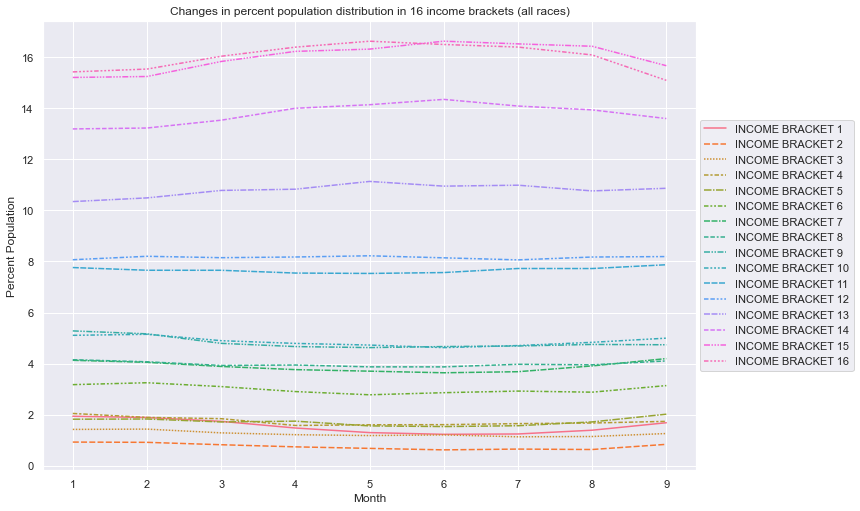

In [5]:
all_income_percent = all_income.T
all_income_percent = all_income_percent.filter(regex='PERCENT', axis=0)

all_income_graph = sns.lineplot(data=all_income_percent)
all_income_graph.set(xlabel='Month', ylabel='Percent Population')
all_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
#Moves legend OUTSIDE of graph (Very cool) :))
all_income_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
all_income_graph.set_title('Changes in percent population distribution in 16 income brackets (all races)')

### Hispanic

In [6]:
# For each month, only consider those that are hispanic
hisp_months = [i[i['pehspnon'] == 1] for i in months]

hisp_income = pd.DataFrame()
for i in range(len(hisp_months)):
    month_income = hisp_months[i]['hefaminc'].value_counts().to_frame()
    num_drop = len([i for i in month_income.index if i < 0])
    month_income = month_income.sort_index().iloc[num_drop:]
    month_income['PERCENT'] = month_income['hefaminc'] / month_income['hefaminc'].sum() * 100
    
    hisp_income['MONTH ' + str(i + 1) + ' INCOME'] = month_income['hefaminc']
    hisp_income['MONTH ' + str(i + 1) + ' PERCENT'] = month_income['PERCENT']

for i in range(1, 17):
    hisp_income = hisp_income.rename(index={i: 'INCOME BRACKET ' + str(i)})

hisp_income

,MONTH 1 INCOME,MONTH 1 PERCENT,MONTH 2 INCOME,MONTH 2 PERCENT,MONTH 3 INCOME,MONTH 3 PERCENT,MONTH 4 INCOME,MONTH 4 PERCENT,MONTH 5 INCOME,MONTH 5 PERCENT,MONTH 6 INCOME,MONTH 6 PERCENT,MONTH 7 INCOME,MONTH 7 PERCENT,MONTH 8 INCOME,MONTH 8 PERCENT,MONTH 9 INCOME,MONTH 9 PERCENT
INCOME BRACKET 1,360,2.087078,384,2.173298,295,2.005030,231,1.655202,183,1.402084,128,1.040228,118,0.934283,165,1.246224,223,1.388629
INCOME BRACKET 2,178,1.031944,198,1.120607,115,0.781622,132,0.945830,136,1.041986,111,0.902072,128,1.013460,133,1.004532,225,1.401084
INCOME BRACKET 3,313,1.814598,324,1.833720,234,1.590430,213,1.526225,181,1.386761,161,1.308411,160,1.266825,160,1.208459,264,1.643938
INCOME BRACKET 4,378,2.191431,401,2.269512,304,2.066200,271,1.941817,246,1.884769,241,1.958553,267,2.114014,286,2.160121,336,2.092285
INCOME BRACKET 5,371,2.150849,382,2.161979,274,1.862299,304,2.178275,249,1.907754,235,1.909793,277,2.193191,282,2.129909,367,2.285323
INCOME BRACKET 6,738,4.278509,758,4.289999,632,4.295521,517,3.704500,492,3.769537,497,4.039009,501,3.966746,490,3.700906,615,3.829628
INCOME BRACKET 7,962,5.577135,947,5.359669,760,5.165500,720,5.159071,666,5.102666,599,4.867940,624,4.940618,709,5.354985,958,5.965502
INCOME BRACKET 8,1057,6.127891,1045,5.914313,778,5.287841,755,5.409860,676,5.179283,630,5.119870,762,6.033254,708,5.347432,924,5.753783
INCOME BRACKET 9,1292,7.490289,1222,6.916068,973,6.613199,915,6.556320,856,6.558382,840,6.826493,846,6.698337,879,6.638973,1057,6.581979
INCOME BRACKET 10,1272,7.374341,1326,7.504669,1077,7.320057,1013,7.258527,959,7.347533,896,7.281593,858,6.793349,904,6.827795,1128,7.024099


### Visualization

<ipython-input-7-10cfd3fc9009>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  hisp_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent Hispanic population distribution in 16 income brackets')

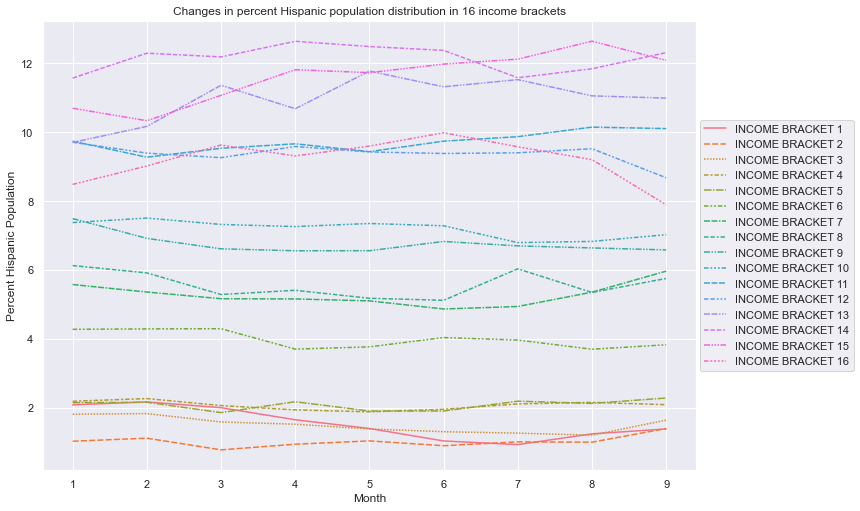

In [7]:
hisp_income_percent = hisp_income.T
hisp_income_percent = hisp_income_percent.filter(regex='PERCENT', axis=0)

hisp_income_graph = sns.lineplot(data=hisp_income_percent)
hisp_income_graph.set(xlabel='Month', ylabel='Percent Hispanic Population')
hisp_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
hisp_income_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
hisp_income_graph.set_title('Changes in percent Hispanic population distribution in 16 income brackets')

### White

In [8]:
white_income = analyze_income_race(1)
white_income

,MONTH 1 INCOME,MONTH 1 PERCENT,MONTH 2 INCOME,MONTH 2 PERCENT,MONTH 3 INCOME,MONTH 3 PERCENT,MONTH 4 INCOME,MONTH 4 PERCENT,MONTH 5 INCOME,MONTH 5 PERCENT,MONTH 6 INCOME,MONTH 6 PERCENT,MONTH 7 INCOME,MONTH 7 PERCENT,MONTH 8 INCOME,MONTH 8 PERCENT,MONTH 9 INCOME,MONTH 9 PERCENT
INCOME BRACKET 1,1364,1.449337,1346,1.425108,1109,1.316352,952,1.164754,858,1.087012,729,0.963699,751,0.971276,877,1.092358,1144,1.290512
INCOME BRACKET 2,677,0.719356,705,0.746435,524,0.621973,463,0.566472,421,0.533370,364,0.481189,402,0.519911,419,0.521891,597,0.673458
INCOME BRACKET 3,1125,1.195384,1130,1.196413,885,1.050470,816,0.998361,787,0.997061,789,1.043016,727,0.940236,769,0.957838,982,1.107765
INCOME BRACKET 4,1631,1.733041,1525,1.614628,1323,1.570364,1134,1.387428,1099,1.392338,1057,1.397298,1095,1.416174,1161,1.446098,1338,1.509357
INCOME BRACKET 5,1631,1.733041,1614,1.708859,1319,1.565616,1289,1.577067,1120,1.418943,1075,1.421093,1101,1.423934,1265,1.575637,1593,1.797015
INCOME BRACKET 6,2872,3.051683,2941,3.113850,2507,2.975738,2274,2.782196,2071,2.623777,2054,2.715279,2095,2.709484,2085,2.596998,2520,2.842736
INCOME BRACKET 7,3764,3.999490,3699,3.916399,3086,3.662995,2939,3.595811,2709,3.432068,2569,3.396082,2653,3.431151,2917,3.633306,3453,3.895225
INCOME BRACKET 8,3810,4.048368,3744,3.964044,3206,3.805432,3090,3.780556,2903,3.677849,2795,3.694842,3006,3.887689,3029,3.772809,3475,3.920042
INCOME BRACKET 9,4910,5.217188,4820,5.103283,4001,4.749074,3849,4.709179,3670,4.649572,3491,4.614917,3631,4.696008,3738,4.655913,4113,4.639751
INCOME BRACKET 10,4755,5.052491,4879,5.165751,4052,4.809610,3811,4.662686,3675,4.655906,3488,4.610951,3690,4.772313,3855,4.801644,4339,4.894695


### Visualization

<ipython-input-9-cdb734b6fa98>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  white_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent White population distribution in 16 income brackets')

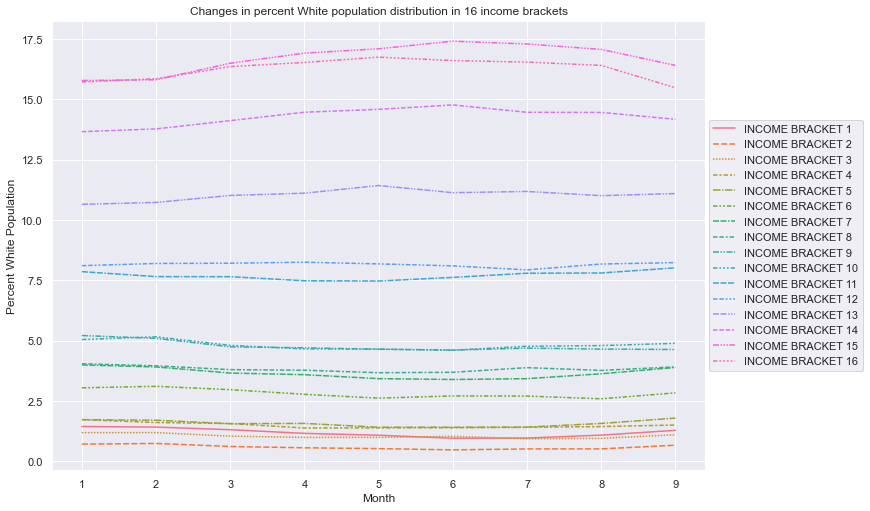

In [9]:
white_income_percent = white_income.T
white_income_percent = white_income_percent.filter(regex='PERCENT', axis=0)

white_income_graph = sns.lineplot(data=white_income_percent)
white_income_graph.set(xlabel='Month', ylabel='Percent White Population')
white_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
white_income_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
white_income_graph.set_title('Changes in percent White population distribution in 16 income brackets')

### Black

In [10]:
black_income = analyze_income_race(2)
black_income

,MONTH 1 INCOME,MONTH 1 PERCENT,MONTH 2 INCOME,MONTH 2 PERCENT,MONTH 3 INCOME,MONTH 3 PERCENT,MONTH 4 INCOME,MONTH 4 PERCENT,MONTH 5 INCOME,MONTH 5 PERCENT,MONTH 6 INCOME,MONTH 6 PERCENT,MONTH 7 INCOME,MONTH 7 PERCENT,MONTH 8 INCOME,MONTH 8 PERCENT,MONTH 9 INCOME,MONTH 9 PERCENT
INCOME BRACKET 1,594,4.916812,577,4.738830,480,4.499016,363,3.594059,244,2.534538,259,2.844591,291,3.131389,337,3.331027,503,4.206389
INCOME BRACKET 2,266,2.201804,234,1.921813,204,1.912082,165,1.633663,136,1.412693,127,1.394838,131,1.409663,136,1.344272,220,1.839773
INCOME BRACKET 3,420,3.476533,420,3.449409,342,3.205549,286,2.831683,251,2.607250,239,2.624931,250,2.690197,263,2.599585,288,2.408430
INCOME BRACKET 4,477,3.948349,457,3.753285,414,3.880401,316,3.128713,341,3.542121,310,3.404723,337,3.626385,354,3.499061,432,3.612644
INCOME BRACKET 5,346,2.864001,376,3.088042,345,3.233668,318,3.148515,251,2.607250,241,2.646897,244,2.625632,293,2.896115,434,3.629369
INCOME BRACKET 6,558,4.618823,582,4.779895,512,4.798950,467,4.623762,442,4.591254,418,4.590884,476,5.122135,512,5.060789,637,5.326978
INCOME BRACKET 7,665,5.504511,685,5.625821,664,6.223639,600,5.940594,613,6.367508,555,6.095552,547,5.886151,631,6.237027,820,6.857334
INCOME BRACKET 8,661,5.471401,661,5.428712,584,5.473803,564,5.584158,569,5.910460,512,5.623284,480,5.165178,585,5.782347,706,5.903997
INCOME BRACKET 9,764,6.323980,769,6.315703,640,5.998688,597,5.910891,541,5.619612,552,6.062603,531,5.713978,616,6.088761,732,6.121425
INCOME BRACKET 10,691,5.719725,685,5.625821,636,5.961196,653,6.465347,560,5.816973,486,5.337727,462,4.971484,567,5.604428,709,5.929085


### Visualization

<ipython-input-11-d10b56053db3>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  black_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent Black population distribution in 16 income brackets')

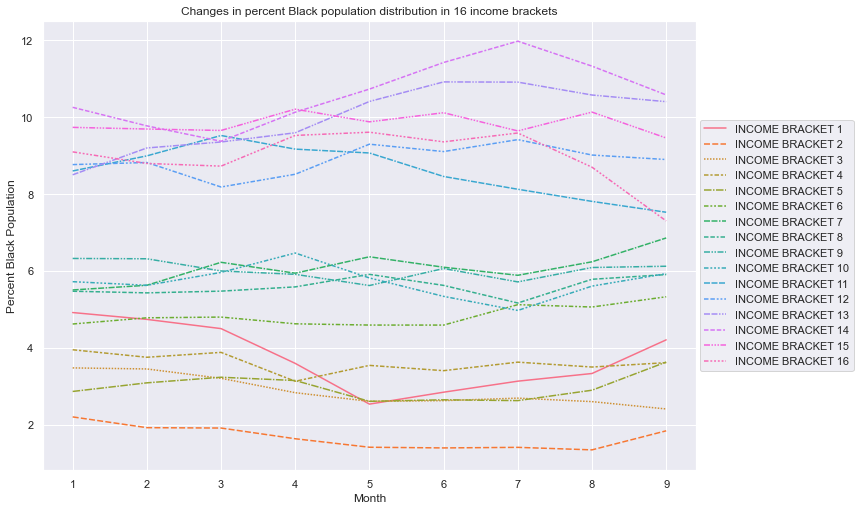

In [11]:
black_income_percent = black_income.T
black_income_percent = black_income_percent.filter(regex='PERCENT', axis=0)

black_income_graph = sns.lineplot(data=black_income_percent)
black_income_graph.set(xlabel='Month', ylabel='Percent Black Population')
black_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
black_income_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
black_income_graph.set_title('Changes in percent Black population distribution in 16 income brackets')

### American Indian, Alaskan Native

In [12]:
native_income = analyze_income_race(3)
native_income

,MONTH 1 INCOME,MONTH 1 PERCENT,MONTH 2 INCOME,MONTH 2 PERCENT,MONTH 3 INCOME,MONTH 3 PERCENT,MONTH 4 INCOME,MONTH 4 PERCENT,MONTH 5 INCOME,MONTH 5 PERCENT,MONTH 6 INCOME,MONTH 6 PERCENT,MONTH 7 INCOME,MONTH 7 PERCENT,MONTH 8 INCOME,MONTH 8 PERCENT,MONTH 9 INCOME,MONTH 9 PERCENT
INCOME BRACKET 1,68,4.228856,61,3.777090,45,3.401361,22,1.729560,38,3.198653,36,3.405866,34,3.082502,41,3.368940,51,3.566434
INCOME BRACKET 2,32,1.990050,29,1.795666,26,1.965231,24,1.886792,23,1.936027,30,2.838221,24,2.175884,21,1.725555,24,1.678322
INCOME BRACKET 3,49,3.047264,57,3.529412,48,3.628118,48,3.773585,35,2.946128,24,2.270577,17,1.541251,24,1.972062,29,2.027972
INCOME BRACKET 4,95,5.907960,81,5.015480,51,3.854875,31,2.437107,23,1.936027,26,2.459792,44,3.989121,45,3.697617,51,3.566434
INCOME BRACKET 5,39,2.425373,36,2.229102,34,2.569917,46,3.616352,49,4.124579,34,3.216651,63,5.711695,48,3.944125,63,4.405594
INCOME BRACKET 6,88,5.472637,95,5.882353,61,4.610733,58,4.559748,48,4.040404,38,3.595080,51,4.623753,72,5.916187,87,6.083916
INCOME BRACKET 7,104,6.467662,94,5.820433,59,4.459562,52,4.088050,53,4.461279,44,4.162725,67,6.074343,81,6.655711,76,5.314685
INCOME BRACKET 8,93,5.783582,83,5.139319,67,5.064248,78,6.132075,75,6.313131,66,6.244087,67,6.074343,69,5.669680,86,6.013986
INCOME BRACKET 9,97,6.032338,75,4.643963,55,4.157218,37,2.908805,61,5.134680,62,5.865658,65,5.893019,93,7.641742,91,6.363636
INCOME BRACKET 10,125,7.773632,111,6.873065,80,6.046863,71,5.581761,78,6.565657,69,6.527909,59,5.349048,82,6.737880,96,6.713287


### Visualization

<ipython-input-13-d4e6a951906a>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  native_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent American Indian and Alaskan Native population distribution in 16 income brackets')

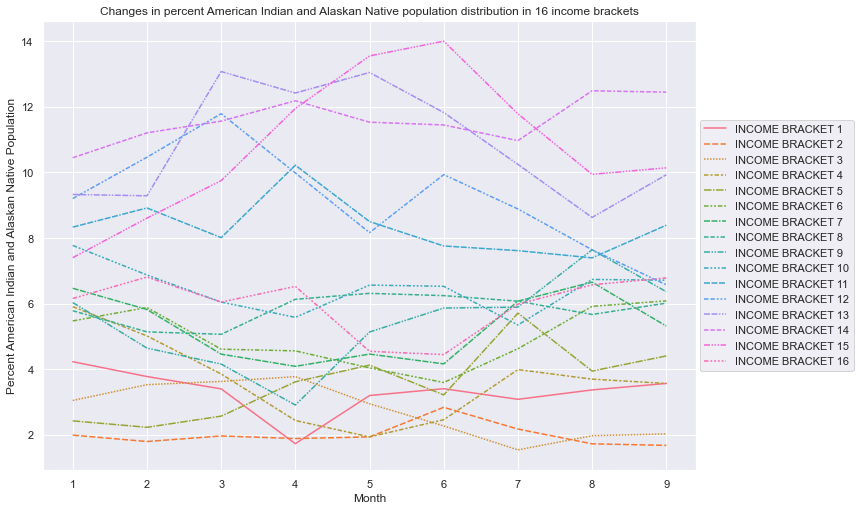

In [13]:
native_income_percent = native_income.T
native_income_percent = native_income_percent.filter(regex='PERCENT', axis=0)

native_income_graph = sns.lineplot(data=native_income_percent)
native_income_graph.set(xlabel='Month', ylabel='Percent American Indian and Alaskan Native Population')
native_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
native_income_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
native_income_graph.set_title('Changes in percent American Indian and Alaskan Native population distribution in 16 income brackets')

### Asian

In [14]:
asian_income = analyze_income_race(4)
asian_income

,MONTH 1 INCOME,MONTH 1 PERCENT,MONTH 2 INCOME,MONTH 2 PERCENT,MONTH 3 INCOME,MONTH 3 PERCENT,MONTH 4 INCOME,MONTH 4 PERCENT,MONTH 5 INCOME,MONTH 5 PERCENT,MONTH 6 INCOME,MONTH 6 PERCENT,MONTH 7 INCOME,MONTH 7 PERCENT,MONTH 8 INCOME,MONTH 8 PERCENT,MONTH 9 INCOME,MONTH 9 PERCENT
INCOME BRACKET 1,166,2.610884,161,2.461774,119,2.048193,108,1.866574,87,1.591658,87,1.664435,78,1.506373,88,1.652893,104,1.736517
INCOME BRACKET 2,54,0.849324,62,0.948012,56,0.963855,49,0.846872,39,0.713502,28,0.535680,26,0.502124,20,0.375657,32,0.534313
INCOME BRACKET 3,41,0.644857,45,0.688073,38,0.654045,45,0.777739,44,0.804976,44,0.841783,46,0.888374,31,0.582269,40,0.667891
INCOME BRACKET 4,107,1.682919,81,1.238532,83,1.428571,63,1.088835,54,0.987925,62,1.186149,41,0.791812,49,0.920361,51,0.851561
INCOME BRACKET 5,65,1.022334,81,1.238532,67,1.153184,82,1.417214,63,1.152580,44,0.841783,39,0.753187,46,0.864012,63,1.051929
INCOME BRACKET 6,115,1.808745,122,1.865443,94,1.617900,87,1.503629,92,1.683132,95,1.817486,89,1.718810,106,1.990984,122,2.037068
INCOME BRACKET 7,176,2.768166,180,2.752294,172,2.960413,142,2.454200,146,2.671057,137,2.621006,116,2.240247,135,2.535687,153,2.554684
INCOME BRACKET 8,191,3.004089,188,2.874618,158,2.719449,164,2.834428,141,2.579583,159,3.041898,169,3.263808,155,2.911345,170,2.838537
INCOME BRACKET 9,231,3.633218,248,3.792049,195,3.356282,165,2.851711,150,2.744237,158,3.022766,154,2.974121,164,3.080391,183,3.055602
INCOME BRACKET 10,275,4.325260,239,3.654434,216,3.717728,189,3.266505,186,3.402854,154,2.946241,168,3.244496,187,3.512397,227,3.790282


### Visualization

<ipython-input-15-db9d2d7ca401>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  asian_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent Asian population distribution in 16 income brackets')

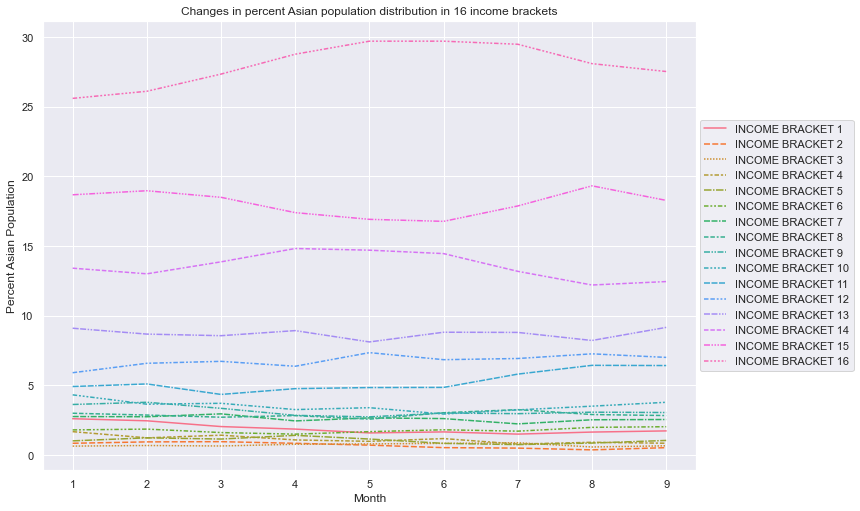

In [15]:
asian_income_percent = asian_income.T
asian_income_percent = asian_income_percent.filter(regex='PERCENT', axis=0)

asian_income_graph = sns.lineplot(data=asian_income_percent)
asian_income_graph.set(xlabel='Month', ylabel='Percent Asian Population')
asian_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
asian_income_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
asian_income_graph.set_title('Changes in percent Asian population distribution in 16 income brackets')

### Hawaiian and Pacific Islander

In [16]:
pacific_income = analyze_income_race(5)
pacific_income

,MONTH 1 INCOME,MONTH 1 PERCENT,MONTH 2 INCOME,MONTH 2 PERCENT,MONTH 3 INCOME,MONTH 3 PERCENT,MONTH 4 INCOME,MONTH 4 PERCENT,MONTH 5 INCOME,MONTH 5 PERCENT,MONTH 6 INCOME,MONTH 6 PERCENT,MONTH 7 INCOME,MONTH 7 PERCENT,MONTH 8 INCOME,MONTH 8 PERCENT,MONTH 9 INCOME,MONTH 9 PERCENT
INCOME BRACKET 1,13,2.6,13,2.680412,8.0,1.927711,3,0.777202,3,0.731707,3,0.793651,7,1.686747,4,0.881057,5,1.075269
INCOME BRACKET 2,12,2.4,11,2.268041,20.0,4.819277,17,4.404145,19,4.634146,9,2.380952,10,2.409639,7,1.541850,12,2.580645
INCOME BRACKET 3,1,0.2,1,0.206186,4.0,0.963855,4,1.036269,3,0.731707,3,0.793651,5,1.204819,11,2.422907,11,2.365591
INCOME BRACKET 4,24,4.8,19,3.917526,8.0,1.927711,13,3.367876,4,0.975610,7,1.851852,11,2.650602,5,1.101322,4,0.860215
INCOME BRACKET 5,4,0.8,1,0.206186,NaN,NaN,2,0.518135,10,2.439024,10,2.645503,8,1.927711,12,2.643172,21,4.516129
INCOME BRACKET 6,11,2.2,19,3.917526,14.0,3.373494,14,3.626943,13,3.170732,7,1.851852,8,1.927711,15,3.303965,22,4.731183
INCOME BRACKET 7,33,6.6,24,4.948454,9.0,2.168675,21,5.440415,14,3.414634,18,4.761905,25,6.024096,17,3.744493,19,4.086022
INCOME BRACKET 8,17,3.4,27,5.567010,27.0,6.506024,33,8.549223,22,5.365854,26,6.878307,22,5.301205,32,7.048458,23,4.946237
INCOME BRACKET 9,34,6.8,35,7.216495,29.0,6.987952,19,4.922280,26,6.341463,30,7.936508,10,2.409639,15,3.303965,20,4.301075
INCOME BRACKET 10,20,4.0,43,8.865979,36.0,8.674699,31,8.031088,34,8.292683,26,6.878307,32,7.710843,42,9.251101,33,7.096774


### Visualization

<ipython-input-17-709c77c9a454>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  pacific_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent Hawaiian and Pacific Islander population distribution in 16 income brackets')

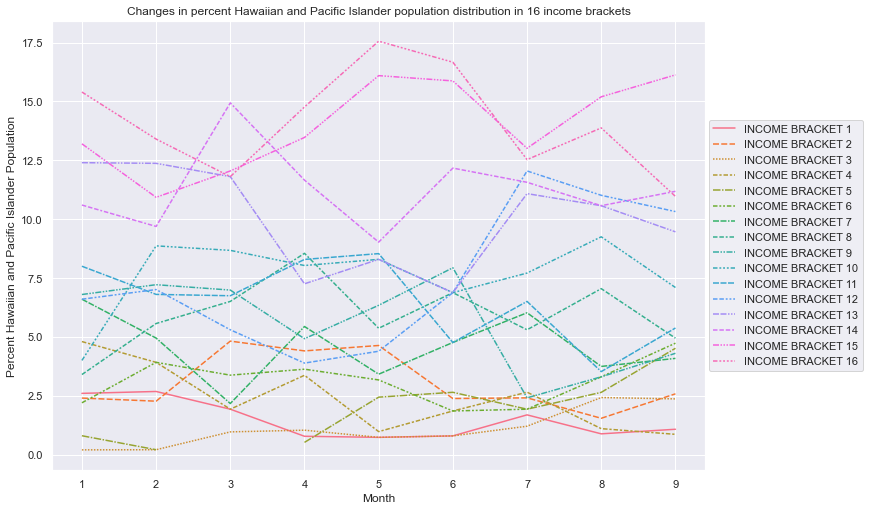

In [17]:
pacific_income_percent = pacific_income.T
pacific_income_percent = pacific_income_percent.filter(regex='PERCENT', axis=0)

pacific_income_graph = sns.lineplot(data=pacific_income_percent)
pacific_income_graph.set(xlabel='Month', ylabel='Percent Hawaiian and Pacific Islander Population')
pacific_income_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
pacific_income_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
pacific_income_graph.set_title('Changes in percent Hawaiian and Pacific Islander population distribution in 16 income brackets')

## Changes in Employment and Labor Force (pemlr) Based on Race

### Overall: All Races

In [24]:
all_emp = pd.DataFrame()

for i in range(len(months)):
    month_emp = months[i]['pemlr'].value_counts().to_frame()
    num_drop = len([i for i in month_emp.index if i < 0])
    month_emp = month_emp.sort_index().iloc[num_drop:]
    month_emp['PERCENT'] = month_emp['pemlr'] / month_emp['pemlr'].sum() * 100
    all_emp['MONTH ' + str(i + 1) + ' EMPLOYMENT'] = month_emp['pemlr']
    all_emp['MONTH ' + str(i + 1) + ' PERCENT'] = month_emp['PERCENT']
for i in range(1, 17):
    all_emp = all_emp.rename(index={i: 'EMPLOYMENT CATEGORY ' + str(i)})
    
all_emp

,MONTH 1 EMPLOYMENT,MONTH 1 PERCENT,MONTH 2 EMPLOYMENT,MONTH 2 PERCENT,MONTH 3 EMPLOYMENT,MONTH 3 PERCENT,MONTH 4 EMPLOYMENT,MONTH 4 PERCENT,MONTH 5 EMPLOYMENT,MONTH 5 PERCENT,MONTH 6 EMPLOYMENT,MONTH 6 PERCENT,MONTH 7 EMPLOYMENT,MONTH 7 PERCENT,MONTH 8 EMPLOYMENT,MONTH 8 PERCENT,MONTH 9 EMPLOYMENT,MONTH 9 PERCENT
EMPLOYMENT CATEGORY 1,54511,56.848022,55310,57.351127,47434,55.176345,38284,45.840867,38947,48.262060,38568,49.889402,39589,50.234110,42630,51.956124,48555,53.313203
EMPLOYMENT CATEGORY 2,1625,1.694668,1595,1.653861,2108,2.452075,3426,4.102257,2420,2.998798,2261,2.924703,2830,3.590960,2420,2.949421,1833,2.012627
EMPLOYMENT CATEGORY 3,411,0.428621,407,0.422020,683,0.794482,5278,6.319823,4088,5.065738,2743,3.548191,2474,3.139235,1714,2.088970,1345,1.476805
EMPLOYMENT CATEGORY 4,1812,1.889685,1765,1.830134,1535,1.785548,1277,1.529067,1465,1.815388,1875,2.425395,1886,2.393128,2039,2.485070,2488,2.731814
EMPLOYMENT CATEGORY 5,19678,20.521645,19489,20.208210,18152,21.114833,18071,21.638029,17905,22.187388,17608,22.776721,17910,22.725831,18261,22.255941,19313,21.205600
EMPLOYMENT CATEGORY 6,4960,5.172648,4938,5.120229,4299,5.000698,4109,4.920074,3881,4.809229,3731,4.826212,3675,4.663173,3876,4.723949,4414,4.846555
EMPLOYMENT CATEGORY 7,12892,13.444712,12937,13.414419,11757,13.676019,13070,15.649883,11993,14.861399,10521,13.609376,10445,13.253562,11110,13.540524,13127,14.413396


<ipython-input-36-8b74d7252b78>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  all_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent population distribution in 7 employment brackets (all races)')

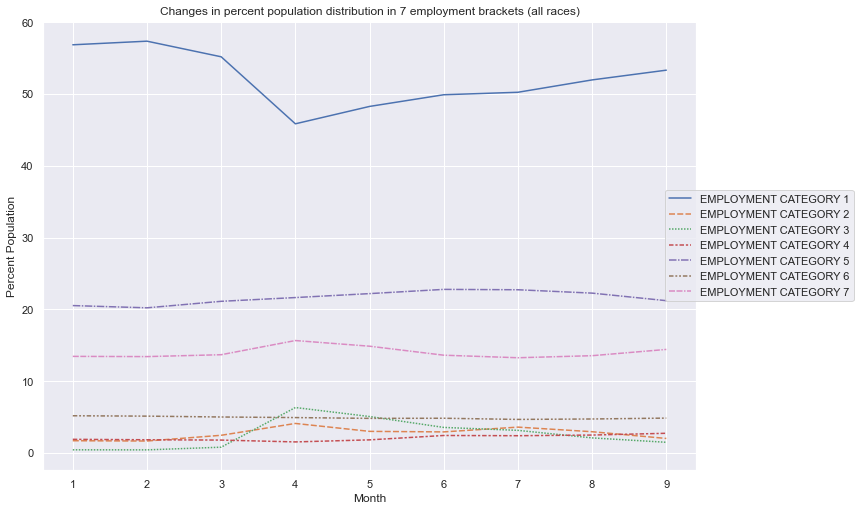

In [36]:
all_emp_percent = all_emp.T
all_emp_percent = all_emp_percent.filter(regex='PERCENT', axis=0)

all_emp_graph = sns.lineplot(data=all_emp_percent)
all_emp_graph.set(xlabel='Month', ylabel='Percent Population')
all_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
#Moves legend OUTSIDE of graph (Very cool) :))
all_emp_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
all_emp_graph.set_title('Changes in percent population distribution in 7 employment brackets (all races)')

### Hispanic

In [38]:
hisp_emp = analyze_emp_race("hispanic")
hisp_emp

,MONTH 1 EMPLOYMENT,MONTH 1 PERCENT,MONTH 2 EMPLOYMENT,MONTH 2 PERCENT,MONTH 3 EMPLOYMENT,MONTH 3 PERCENT,MONTH 4 EMPLOYMENT,MONTH 4 PERCENT,MONTH 5 EMPLOYMENT,MONTH 5 PERCENT,MONTH 6 EMPLOYMENT,MONTH 6 PERCENT,MONTH 7 EMPLOYMENT,MONTH 7 PERCENT,MONTH 8 EMPLOYMENT,MONTH 8 PERCENT,MONTH 9 EMPLOYMENT,MONTH 9 PERCENT
EMPLOYMENT BRACKET 1,7740,60.228776,8036,60.920324,6266,57.124624,4659,44.746446,4636,47.344771,4719,51.071429,4865,51.448816,5332,53.956689,6590,55.285235
EMPLOYMENT BRACKET 2,215,1.673022,169,1.281177,292,2.662048,500,4.802151,323,3.298611,263,2.846320,287,3.035110,258,2.610808,212,1.778523
EMPLOYMENT BRACKET 3,99,0.770368,96,0.727769,161,1.467773,914,8.778333,767,7.832925,468,5.064935,424,4.483926,302,3.056062,280,2.348993
EMPLOYMENT BRACKET 4,332,2.583457,320,2.425896,275,2.507065,226,2.170572,240,2.450980,351,3.798701,347,3.669628,343,3.470957,443,3.716443
EMPLOYMENT BRACKET 5,1244,9.680181,1254,9.506482,1123,10.237943,1065,10.228582,1066,10.886438,1026,11.103896,1051,11.114636,1043,10.554544,1218,10.218121
EMPLOYMENT BRACKET 6,509,3.960781,518,3.926920,438,3.993071,394,3.784095,369,3.768382,349,3.777056,350,3.701354,374,3.784659,444,3.724832
EMPLOYMENT BRACKET 7,2712,21.103416,2798,21.211432,2414,22.007476,2654,25.489819,2391,24.417892,2064,22.337662,2132,22.546531,2230,22.566282,2733,22.927852


### Visualization

<ipython-input-40-1d4f53d5b751>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  hisp_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent Hispanic population distribution in 7 employment brackets')

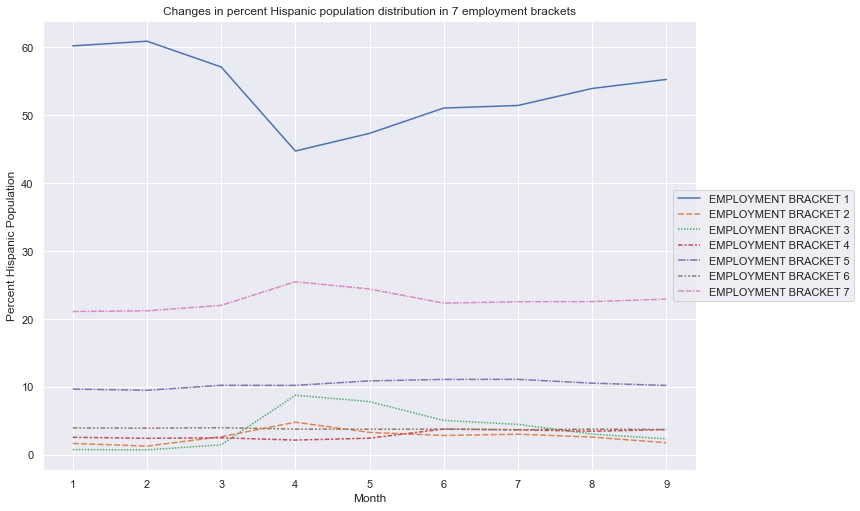

In [40]:
hisp_emp_percent = hisp_emp.T
hisp_emp_percent = hisp_emp_percent.filter(regex='PERCENT', axis=0)

hisp_emp_graph = sns.lineplot(data=hisp_emp_percent)
hisp_emp_graph.set(xlabel='Month', ylabel='Percent Hispanic Population')
hisp_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
hisp_emp_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
hisp_emp_graph.set_title('Changes in percent Hispanic population distribution in 7 employment brackets')

### White

In [44]:
white_emp = analyze_emp_race(1)
white_emp

,MONTH 1 EMPLOYMENT,MONTH 1 PERCENT,MONTH 2 EMPLOYMENT,MONTH 2 PERCENT,MONTH 3 EMPLOYMENT,MONTH 3 PERCENT,MONTH 4 EMPLOYMENT,MONTH 4 PERCENT,MONTH 5 EMPLOYMENT,MONTH 5 PERCENT,MONTH 6 EMPLOYMENT,MONTH 6 PERCENT,MONTH 7 EMPLOYMENT,MONTH 7 PERCENT,MONTH 8 EMPLOYMENT,MONTH 8 PERCENT,MONTH 9 EMPLOYMENT,MONTH 9 PERCENT
EMPLOYMENT BRACKET 1,44573,57.275578,45054,57.696445,38747,55.493970,31617,46.562693,32386,49.200899,31921,50.528699,32636,50.648706,35062,52.482524,39700,54.054054
EMPLOYMENT BRACKET 2,1330,1.709028,1283,1.643018,1719,2.461975,2693,3.966010,1845,2.802929,1864,2.950581,2410,3.740145,2023,3.028126,1481,2.016475
EMPLOYMENT BRACKET 3,346,0.444604,364,0.466141,566,0.810633,4145,6.104386,3161,4.802200,2074,3.282996,1846,2.864858,1252,1.874055,925,1.259446
EMPLOYMENT BRACKET 4,1272,1.634499,1251,1.602039,1065,1.525307,937,1.379930,1076,1.634662,1411,2.233514,1410,2.188218,1467,2.195878,1821,2.479406
EMPLOYMENT BRACKET 5,16915,21.735499,16733,21.428388,15704,22.491478,15660,23.062649,15466,23.495989,15203,24.065280,15471,24.009870,15782,23.623273,16625,22.635986
EMPLOYMENT BRACKET 6,3686,4.736450,3647,4.670372,3173,4.544413,3064,4.512385,2873,4.364669,2772,4.387881,2783,4.319014,2886,4.319907,3255,4.431888
EMPLOYMENT BRACKET 7,9700,12.464342,9756,12.493597,8848,12.672224,9786,14.411947,9017,13.698651,7929,12.551049,7880,12.229189,8335,12.476238,9638,13.122745


### Visualization

<ipython-input-45-6e0ccb657645>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  white_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent White population distribution in 7 employment brackets')

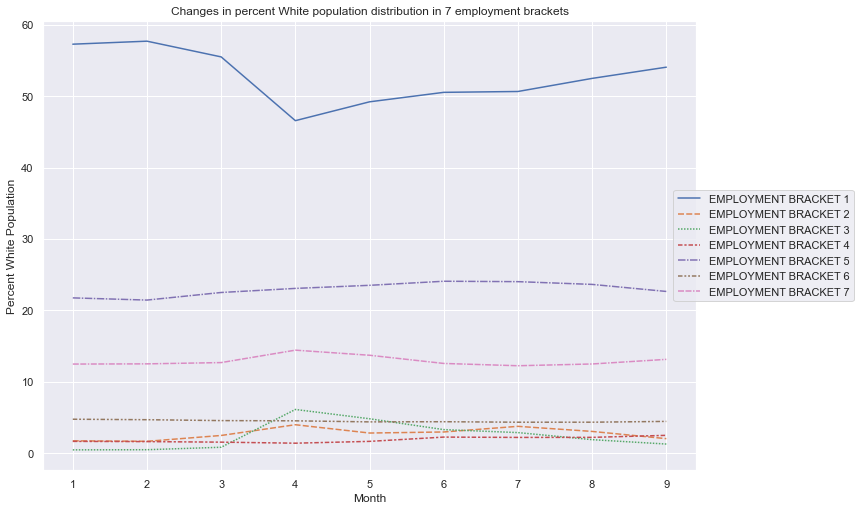

In [45]:
white_emp_percent = white_emp.T
white_emp_percent = white_emp_percent.filter(regex='PERCENT', axis=0)

white_emp_graph = sns.lineplot(data=white_emp_percent)
white_emp_graph.set(xlabel='Month', ylabel='Percent White Population')
white_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
white_emp_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
white_emp_graph.set_title('Changes in percent White population distribution in 7 employment brackets')

### Black

In [47]:
black_emp = analyze_emp_race(2)
black_emp

,MONTH 1 EMPLOYMENT,MONTH 1 PERCENT,MONTH 2 EMPLOYMENT,MONTH 2 PERCENT,MONTH 3 EMPLOYMENT,MONTH 3 PERCENT,MONTH 4 EMPLOYMENT,MONTH 4 PERCENT,MONTH 5 EMPLOYMENT,MONTH 5 PERCENT,MONTH 6 EMPLOYMENT,MONTH 6 PERCENT,MONTH 7 EMPLOYMENT,MONTH 7 PERCENT,MONTH 8 EMPLOYMENT,MONTH 8 PERCENT,MONTH 9 EMPLOYMENT,MONTH 9 PERCENT
EMPLOYMENT BRACKET 1,5086,53.095313,5226,53.848532,4404,51.581167,3345,41.037909,3334,42.395727,3327,44.723753,3405,44.992072,3845,47.177914,4561,47.804213
EMPLOYMENT BRACKET 2,146,1.524167,142,1.463163,181,2.119934,363,4.453441,276,3.509664,214,2.876731,247,3.263742,230,2.822086,212,2.221989
EMPLOYMENT BRACKET 3,36,0.375822,20,0.206079,49,0.573905,531,6.514538,449,5.709563,328,4.409195,321,4.241543,222,2.723926,189,1.980924
EMPLOYMENT BRACKET 4,336,3.507673,337,3.472437,305,3.572265,187,2.294197,215,2.733978,259,3.481651,271,3.580867,348,4.269939,424,4.443979
EMPLOYMENT BRACKET 5,1567,16.358701,1570,16.177228,1424,16.678379,1408,17.273954,1453,18.476602,1416,19.034817,1451,19.172833,1447,17.754601,1556,16.308563
EMPLOYMENT BRACKET 6,937,9.781814,952,9.809377,856,10.025767,784,9.618452,769,9.778739,741,9.961016,669,8.839852,734,9.006135,880,9.223352
EMPLOYMENT BRACKET 7,1471,15.356509,1458,15.023184,1319,15.448583,1533,18.807508,1368,17.395727,1154,15.512838,1204,15.909091,1324,16.245399,1719,18.016979


<ipython-input-49-e31a832be6aa>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  black_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent Black population distribution in 7 employment brackets')

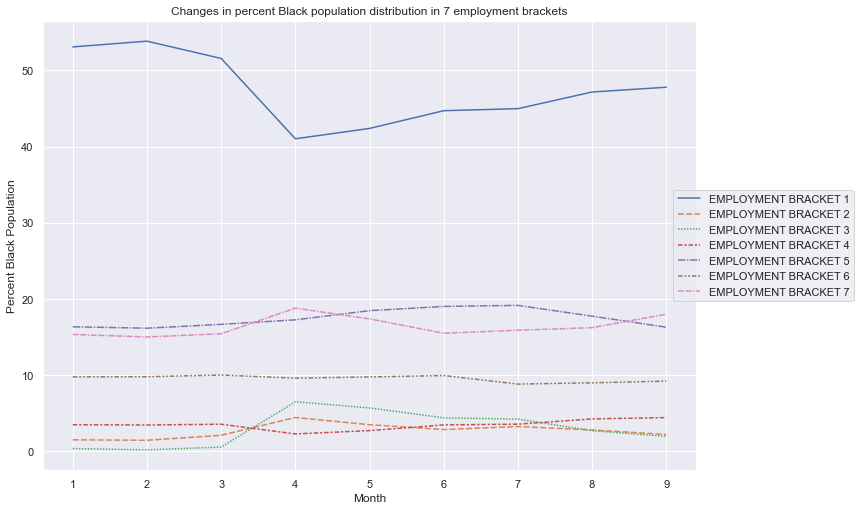

In [49]:
black_emp_percent = black_emp.T
black_emp_percent = black_emp_percent.filter(regex='PERCENT', axis=0)

black_emp_graph = sns.lineplot(data=black_emp_percent)
black_emp_graph.set(xlabel='Month', ylabel='Percent Black Population')
black_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
black_emp_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
black_emp_graph.set_title('Changes in percent Black population distribution in 7 employment brackets')

### American Indian and Alaskan Native

In [51]:
native_emp = analyze_emp_race(3)
native_emp

,MONTH 1 EMPLOYMENT,MONTH 1 PERCENT,MONTH 2 EMPLOYMENT,MONTH 2 PERCENT,MONTH 3 EMPLOYMENT,MONTH 3 PERCENT,MONTH 4 EMPLOYMENT,MONTH 4 PERCENT,MONTH 5 EMPLOYMENT,MONTH 5 PERCENT,MONTH 6 EMPLOYMENT,MONTH 6 PERCENT,MONTH 7 EMPLOYMENT,MONTH 7 PERCENT,MONTH 8 EMPLOYMENT,MONTH 8 PERCENT,MONTH 9 EMPLOYMENT,MONTH 9 PERCENT
EMPLOYMENT BRACKET 1,594,47.941889,597,48.974569,482,47.162427,374,38.836968,384,43.194601,380,46.913580,392,45.901639,426,45.806452,544,49.454545
EMPLOYMENT BRACKET 2,12,0.968523,23,1.886792,30,2.935421,30,3.115265,22,2.474691,23,2.839506,22,2.576112,28,3.010753,27,2.454545
EMPLOYMENT BRACKET 3,6,0.484262,13,1.066448,15,1.467710,92,9.553479,56,6.299213,25,3.086420,34,3.981265,19,2.043011,15,1.363636
EMPLOYMENT BRACKET 4,53,4.277643,42,3.445447,32,3.131115,39,4.049844,39,4.386952,41,5.061728,30,3.512881,38,4.086022,32,2.909091
EMPLOYMENT BRACKET 5,196,15.819209,179,14.684167,147,14.383562,121,12.564901,111,12.485939,108,13.333333,128,14.988290,124,13.333333,129,11.727273
EMPLOYMENT BRACKET 6,111,8.958838,104,8.531583,92,9.001957,79,8.203531,84,9.448819,71,8.765432,61,7.142857,66,7.096774,84,7.636364
EMPLOYMENT BRACKET 7,267,21.549637,261,21.410993,224,21.917808,228,23.676012,193,21.709786,162,20.000000,187,21.896956,229,24.623656,269,24.454545


### Visualization

<ipython-input-53-805bbb735dab>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  native_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent American Indian and Alaskan Native population distribution in 7 employment brackets')

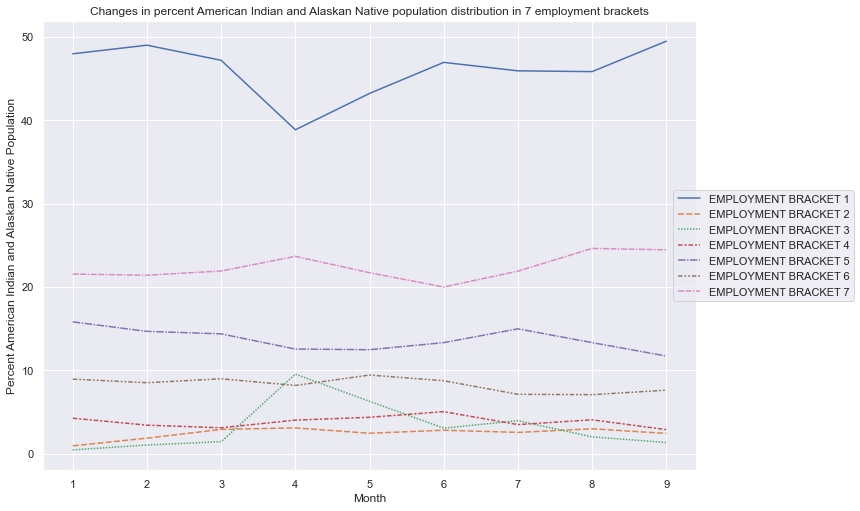

In [53]:
native_emp_percent = native_emp.T
native_emp_percent = native_emp_percent.filter(regex='PERCENT', axis=0)

native_emp_graph = sns.lineplot(data=native_emp_percent)
native_emp_graph.set(xlabel='Month', ylabel='Percent American Indian and Alaskan Native Population')
native_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
native_emp_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
native_emp_graph.set_title('Changes in percent American Indian and Alaskan Native population distribution in 7 employment brackets')

### Asian

In [55]:
asian_emp = analyze_emp_race(4)
asian_emp

,MONTH 1 EMPLOYMENT,MONTH 1 PERCENT,MONTH 2 EMPLOYMENT,MONTH 2 PERCENT,MONTH 3 EMPLOYMENT,MONTH 3 PERCENT,MONTH 4 EMPLOYMENT,MONTH 4 PERCENT,MONTH 5 EMPLOYMENT,MONTH 5 PERCENT,MONTH 6 EMPLOYMENT,MONTH 6 PERCENT,MONTH 7 EMPLOYMENT,MONTH 7 PERCENT,MONTH 8 EMPLOYMENT,MONTH 8 PERCENT,MONTH 9 EMPLOYMENT,MONTH 9 PERCENT
EMPLOYMENT BRACKET 1,3080,58.444023,3269,60.025707,2807,58.345458,2179,45.623953,2113,46.603441,2167,49.907877,2288,53.395566,2431,54.752252,2770,55.289421
EMPLOYMENT BRACKET 2,109,2.068311,118,2.166728,126,2.618998,255,5.339196,215,4.741950,105,2.418240,104,2.427071,100,2.252252,69,1.377246
EMPLOYMENT BRACKET 3,15,0.284630,5,0.091811,41,0.852214,360,7.537688,308,6.793119,246,5.665592,198,4.620770,159,3.581081,165,3.293413
EMPLOYMENT BRACKET 4,94,1.783681,76,1.395520,77,1.600499,75,1.570352,95,2.095280,108,2.487333,113,2.637106,115,2.590090,128,2.554890
EMPLOYMENT BRACKET 5,794,15.066414,787,14.450973,686,14.258990,698,14.614740,692,15.262461,720,16.582220,683,15.939323,711,16.013514,782,15.608782
EMPLOYMENT BRACKET 6,109,2.068311,119,2.185090,96,1.995427,97,2.030988,83,1.830613,77,1.773376,71,1.656943,79,1.779279,66,1.317365
EMPLOYMENT BRACKET 7,1069,20.284630,1072,19.684172,978,20.328414,1112,23.283082,1028,22.673136,919,21.165362,828,19.323221,845,19.031532,1030,20.558882


### Visualization

<ipython-input-58-910c10121f54>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  asian_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent Asian population distribution in 7 employment brackets')

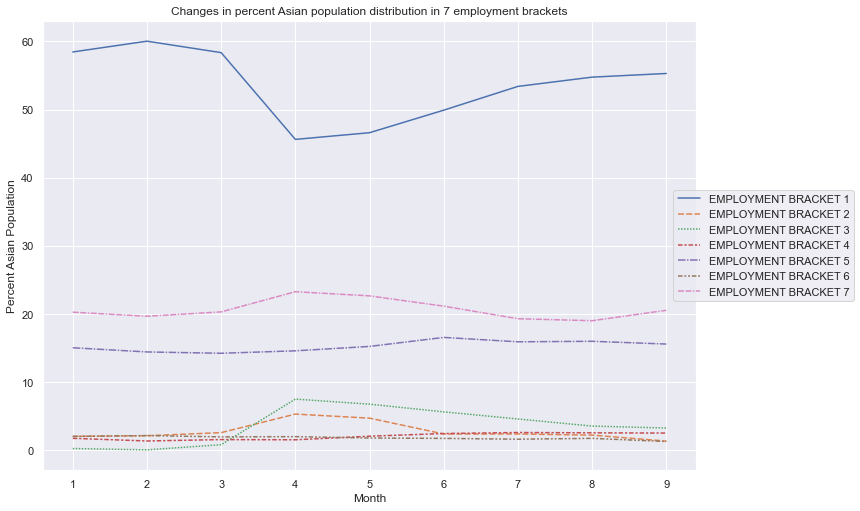

In [58]:
asian_emp_percent = asian_emp.T
asian_emp_percent = asian_emp_percent.filter(regex='PERCENT', axis=0)

asian_emp_graph = sns.lineplot(data=asian_emp_percent)
asian_emp_graph.set(xlabel='Month', ylabel='Percent Asian Population')
asian_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
asian_emp_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
asian_emp_graph.set_title('Changes in percent Asian population distribution in 7 employment brackets')

### Hawaiian and Pacific Islander

In [60]:
pacific_emp = analyze_emp_race(5)
pacific_emp

,MONTH 1 EMPLOYMENT,MONTH 1 PERCENT,MONTH 2 EMPLOYMENT,MONTH 2 PERCENT,MONTH 3 EMPLOYMENT,MONTH 3 PERCENT,MONTH 4 EMPLOYMENT,MONTH 4 PERCENT,MONTH 5 EMPLOYMENT,MONTH 5 PERCENT,MONTH 6 EMPLOYMENT,MONTH 6 PERCENT,MONTH 7 EMPLOYMENT,MONTH 7 PERCENT,MONTH 8 EMPLOYMENT,MONTH 8 PERCENT,MONTH 9 EMPLOYMENT,MONTH 9 PERCENT
EMPLOYMENT BRACKET 1,267,66.417910,243.0,61.989796,199,61.801242,163,54.333333,162,51.923077,150,53.191489,165,53.398058,185,52.706553,164,45.179063
EMPLOYMENT BRACKET 2,3,0.746269,4.0,1.020408,11,3.416149,11,3.666667,15,4.807692,14,4.964539,9,2.912621,7,1.994302,7,1.928375
EMPLOYMENT BRACKET 3,2,0.497512,NaN,NaN,1,0.310559,20,6.666667,25,8.012821,16,5.673759,15,4.854369,18,5.128205,8,2.203857
EMPLOYMENT BRACKET 4,4,0.995025,6.0,1.530612,5,1.552795,4,1.333333,4,1.282051,4,1.418440,9,2.912621,12,3.418803,16,4.407713
EMPLOYMENT BRACKET 5,33,8.208955,41.0,10.459184,33,10.248447,29,9.666667,34,10.897436,30,10.638298,32,10.355987,43,12.250712,47,12.947658
EMPLOYMENT BRACKET 6,23,5.721393,24.0,6.122449,13,4.037267,14,4.666667,8,2.564103,9,3.191489,11,3.559871,18,5.128205,23,6.336088
EMPLOYMENT BRACKET 7,70,17.412935,74.0,18.877551,60,18.633540,59,19.666667,64,20.512821,59,20.921986,68,22.006472,68,19.373219,98,26.997245


### Visualization

<ipython-input-63-8802b4cd5644>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  pacific_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Changes in percent Hawaiian and Pacific Islander population distribution in 7 employment brackets')

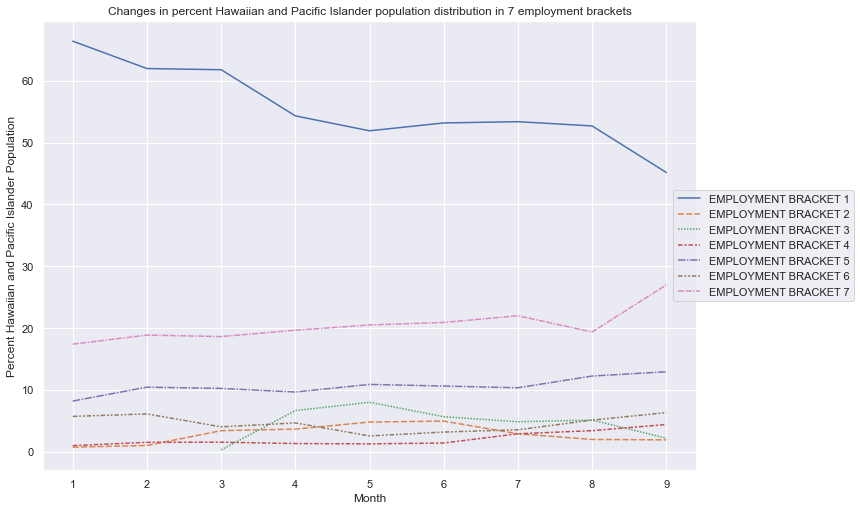

In [63]:
pacific_emp_percent = pacific_emp.T
pacific_emp_percent = pacific_emp_percent.filter(regex='PERCENT', axis=0)

pacific_emp_graph = sns.lineplot(data=pacific_emp_percent)
pacific_emp_graph.set(xlabel='Month', ylabel='Percent Hawaiian and Pacific Islander Population')
pacific_emp_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
pacific_emp_graph.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
pacific_emp_graph.set_title('Changes in percent Hawaiian and Pacific Islander population distribution in 7 employment brackets')

## Unemployment and Labor Force Participation Rates Based on Race

### Unemployment Rate

In [91]:
uer_race = pd.DataFrame()

# Get overall unemployment rates
for i in range(len(months)):
    month = months[i]
    emp = month[(month['pemlr'] == 1) | (month['pemlr'] == 2)].shape[0]
    unemp = month[(month['pemlr'] == 3) | (month['pemlr'] == 4)].shape[0]
    unemp_rate = unemp / (unemp + emp) * 100
    uer_race.loc['All Races Combined', 'Month ' + str(i + 1) + ' Unemployment Rate'] = unemp_rate

races = ['', 'White', 'Black', 'American Indian and Alaskan Native', 'Asian', 'Hawaiian and Pacific Islander']

# Get unemployment rates for only Hispanics
hisp_months = [i[i['pehspnon'] == 1] for i in months]
for i in range(len(hisp_months)):
    hisp_month = hisp_months[i]
    hisp_emp = hisp_month[(hisp_month['pemlr'] == 1) | (hisp_month['pemlr'] == 2)].shape[0]
    hisp_unemp = hisp_month[(hisp_month['pemlr'] == 3) | (hisp_month['pemlr'] == 4)].shape[0]
    hisp_unemp_rate = hisp_unemp / (hisp_emp + hisp_unemp) * 100
    uer_race.loc['Hispanic', 'Month ' + str(i + 1) + ' Unemployment Rate'] = hisp_unemp_rate

# Get unemployment rates for all other races
for race in range(1, 6):
    race_months = [i[i['ptdtrace'] == race] for i in months]
    for i in range(len(race_months)):
        race_month = race_months[i]
        race_emp = race_month[(race_month['pemlr'] == 1) | (race_month['pemlr'] == 2)].shape[0]
        race_unemp = race_month[(race_month['pemlr'] == 3) | (race_month['pemlr'] == 4)].shape[0]
        race_unemp_rate = race_unemp / (race_unemp + race_emp) * 100
        uer_race.loc[races[race], 'Month ' + str(i + 1) + ' Unemployment Rate'] = race_unemp_rate
        
uer_race

,Month 1 Unemployment Rate,Month 2 Unemployment Rate,Month 3 Unemployment Rate,Month 4 Unemployment Rate,Month 5 Unemployment Rate,Month 6 Unemployment Rate,Month 7 Unemployment Rate,Month 8 Unemployment Rate,Month 9 Unemployment Rate
All Races Combined,3.809181,3.676558,4.285162,13.581270,11.835038,10.161287,9.320422,7.690101,7.069217
Hispanic,5.139518,4.825426,6.233915,18.098111,16.878981,14.118255,13.017052,10.344828,9.607973
White,3.404811,3.367951,3.874385,12.901097,11.014350,9.350684,8.500862,6.830972,6.251281
Black,6.638116,6.235808,7.167443,16.222323,15.535798,14.219961,13.949105,12.271259,11.381359
American Indian and Alaskan Native,8.872180,8.148148,8.407871,24.485981,18.962076,14.072495,13.389121,11.154599,7.605178
Asian,3.305033,2.335640,3.867584,15.162077,14.756499,13.480579,11.505734,9.768271,9.355045
Hawaiian and Pacific Islander,2.173913,2.371542,2.777778,12.121212,14.077670,10.869565,12.121212,13.513514,12.307692


### Visualization

<ipython-input-99-050c46b4c2fd>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  uer_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Unemployment Rate by Race')

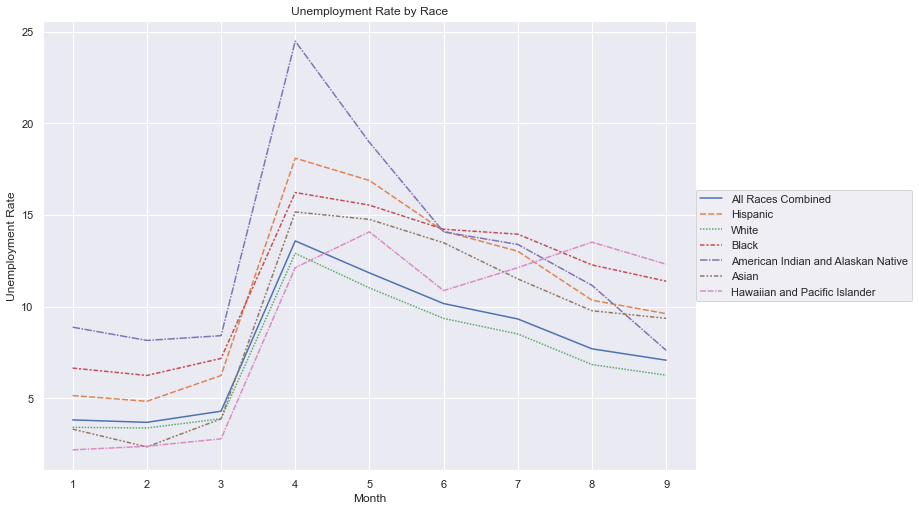

In [99]:
uer_raceT = uer_race.T

uer_graph = sns.lineplot(data=uer_raceT)
uer_graph.set(xlabel='Month', ylabel='Unemployment Rate')
uer_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
uer_graph.legend(loc='center right', bbox_to_anchor=(1.34, 0.5), ncol=1)
uer_graph.set_title('Unemployment Rate by Race')

### Labor Force Participation Rate

In [106]:
lfpr_race = pd.DataFrame()

# Get overall unemployment rates
for i in range(len(months)):
    month = months[i]
    labor_force = month[(month['pemlr'] == 1) | (month['pemlr'] == 2) | 
                        (month['pemlr'] == 3) | (month['pemlr'] == 4)].shape[0]
    population = month[month['pemlr'] > 0].shape[0]
    lfpr = labor_force / population * 100
    lfpr_race.loc['All Races Combined', 'Month ' + str(i + 1) + ' Labor Force Participation Rate'] = lfpr

races = ['', 'White', 'Black', 'American Indian and Alaskan Native', 'Asian', 'Hawaiian and Pacific Islander']

# Get unemployment rates for only Hispanics
hisp_months = [i[i['pehspnon'] == 1] for i in months]
for i in range(len(hisp_months)):
    hisp_month = hisp_months[i]
    hisp_lf = hisp_month[(hisp_month['pemlr'] == 1) | (hisp_month['pemlr'] == 2) | 
                         (hisp_month['pemlr'] == 3) | (hisp_month['pemlr'] == 4)].shape[0]
    hisp_pop = hisp_month[hisp_month['pemlr'] > 0].shape[0]
    hisp_lfpr = hisp_lf / hisp_pop * 100
    lfpr_race.loc['Hispanic', 'Month ' + str(i + 1) + ' Labor Force Participation Rate'] = hisp_lfpr

# Get unemployment rates for all other races
for race in range(1, 6):
    race_months = [i[i['ptdtrace'] == race] for i in months]
    for i in range(len(race_months)):
        race_month = race_months[i]
        race_lf = race_month[(race_month['pemlr'] == 1) | (race_month['pemlr'] == 2) | 
                             (race_month['pemlr'] == 3) | (race_month['pemlr'] == 4)].shape[0]
        race_pop = race_month[race_month['pemlr'] > 0].shape[0]
        race_lfpr = race_lf / race_pop * 100
        lfpr_race.loc[races[race], 'Month ' + str(i + 1) + ' Labor Force Participation Rate'] = race_lfpr

lfpr_race

,Month 1 Labor Force Participation Rate,Month 2 Labor Force Participation Rate,Month 3 Labor Force Participation Rate,Month 4 Labor Force Participation Rate,Month 5 Labor Force Participation Rate,Month 6 Labor Force Participation Rate,Month 7 Labor Force Participation Rate,Month 8 Labor Force Participation Rate,Month 9 Labor Force Participation Rate
All Races Combined,60.860996,61.257142,60.208450,57.792013,58.141984,58.787691,59.357434,59.479586,59.534450
Hispanic,65.255622,65.355166,63.761510,60.497503,60.927288,62.781385,62.637479,63.094515,63.129195
White,61.063709,61.407643,60.291885,58.013019,58.440690,58.995789,59.441927,59.580583,59.809381
Black,58.502975,58.990211,57.847271,54.300086,54.348932,55.491329,56.078224,56.993865,56.451106
American Indian and Alaskan Native,53.672316,55.373257,54.696673,55.555556,56.355456,57.901235,55.971897,54.946237,56.181818
Asian,62.580645,63.679765,63.417169,60.071189,60.233789,60.479042,63.080513,63.175676,62.514970
Hawaiian and Pacific Islander,68.656716,64.540816,67.080745,66.000000,66.025641,65.248227,64.077670,63.247863,53.719008


### Visualization

<ipython-input-107-9fc0015c54b7>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  lfpr_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])


Text(0.5, 1.0, 'Labor Force Participation Rate by Race')

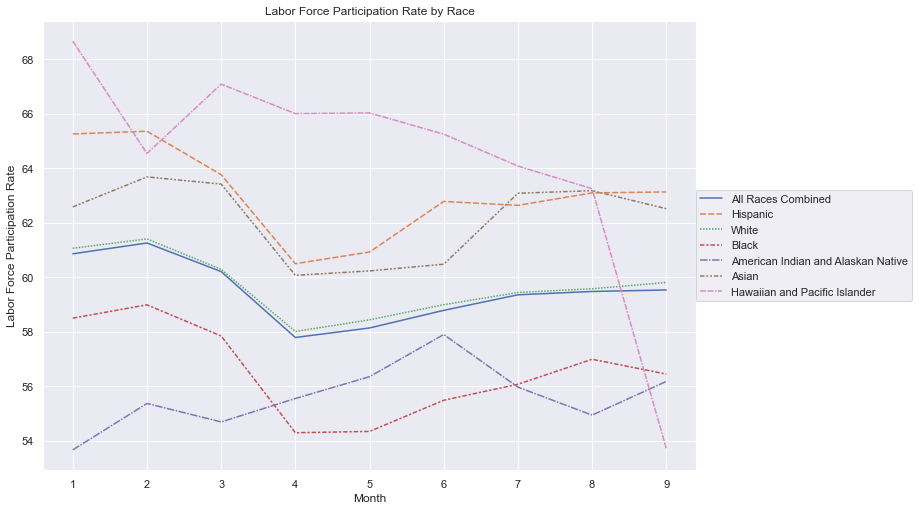

In [107]:
lfpr_raceT = lfpr_race.T

lfpr_graph = sns.lineplot(data=lfpr_raceT)
lfpr_graph.set(xlabel='Month', ylabel='Labor Force Participation Rate')
lfpr_graph.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
lfpr_graph.legend(loc='center right', bbox_to_anchor=(1.34, 0.5), ncol=1)
lfpr_graph.set_title('Labor Force Participation Rate by Race')